## 0. Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from os.path import join
import os
import datetime
from datetime import date
import pickle
import math
import time
import pickle

DATA_PATH = 'data/'
TRAIN_PATH= os.path.join(DATA_PATH, 'train.csv')
TEST_PATH = os.path.join(DATA_PATH, 'test_x.csv')
TWEETS_PATH = os.path.join(DATA_PATH, 'tweets_from2015_#Ibex35.csv')

In [7]:
# TO SAVE INTERMEDIATE DATASETS OR MODELS

def save_pickle(dir, filename, data):
  pickle_out = open( join(dir, f'{filename}.pckl'), 'wb')
  pickle.dump(data, pickle_out)
  pickle_out.close()

def load_pickle(dir, filename):
  pickle_in = open( join(dir, f'{filename}.pckl'), 'rb' )
  data = pickle.load(pickle_in)
  pickle_in.close()
  return data

## 1. Analisis

In [3]:
df = pd.read_csv(TRAIN_PATH)
df_test = pd.read_csv(TEST_PATH)
print(df.shape, "raw shape test")
print(df_test.shape, "raw shape test")

# Change columns name
new_col_names = {x : x.lower() for x in df.columns}
df.rename(columns=new_col_names, inplace=True)

# Set date as index to sort per date
df.index = pd.to_datetime(df.date)
df.sort_index(inplace=True)

# Remove duplicate rows
df = df[~df.index.duplicated(keep='first')]
print(df.shape, "without duplicates")
print("from:", df.index.min(), " to:", df.index.max())

# Volume == 0 considered an error
condicion = df['volume'] == 0
df.loc[condicion, 'volume'] = np.nan

(6554, 8) raw shape test
(726, 8) raw shape test
(6554, 8) without duplicates
from: 1994-01-03 00:00:00  to: 2019-05-30 00:00:00


In [4]:
df.describe()

,open,high,low,close,adj close,volume,target
count,6421.000000,6421.000000,6421.000000,6421.000000,6421.000000,4.772000e+03,6554.000000
mean,8936.540448,9005.235576,8858.340567,8934.978558,8934.970624,1.105789e+08,0.516936
std,2732.102441,2749.009324,2712.511028,2731.032625,2731.030170,1.314467e+08,0.499751
min,2865.100098,2877.300049,2833.600098,2865.100098,2865.097168,3.780000e+04,0.000000
25%,7732.399902,7817.200195,7641.500000,7727.799805,7727.791992,1.608000e+05,0.000000
50%,9329.700195,9404.599609,9243.000000,9331.000000,9331.000000,7.775250e+06,1.000000
75%,10525.500000,10590.299805,10441.200195,10523.400391,10523.400391,2.142067e+08,1.000000
max,15999.200195,16040.400391,15868.599609,15945.700195,15945.683594,7.894902e+08,1.000000


In [8]:
df_test.describe()

,test_index,Open,High,Low,Close,Adj Close,Volume
count,726.000000,726.000000,726.000000,726.000000,726.000000,726.000000,7.260000e+02
mean,6919.500000,8399.936418,8458.035202,8332.158471,8396.085609,8396.085609,2.086387e+08
std,209.722436,899.325142,886.671165,916.904022,903.320144,903.320144,1.015796e+08
min,6557.000000,6223.700195,6362.500000,5814.500000,6107.200195,6107.200195,3.543620e+07
25%,6738.250000,7848.675049,7963.874878,7762.924805,7857.675171,7857.675171,1.472686e+08
50%,6919.500000,8673.950195,8725.250000,8609.750000,8672.399902,8672.399902,1.827458e+08
75%,7100.750000,9077.599609,9124.224854,9001.125244,9077.375244,9077.375244,2.340954e+08
max,7282.000000,10048.700195,10100.200195,10020.700195,10083.599609,10083.599609,9.752120e+08


### 1.1 Plots

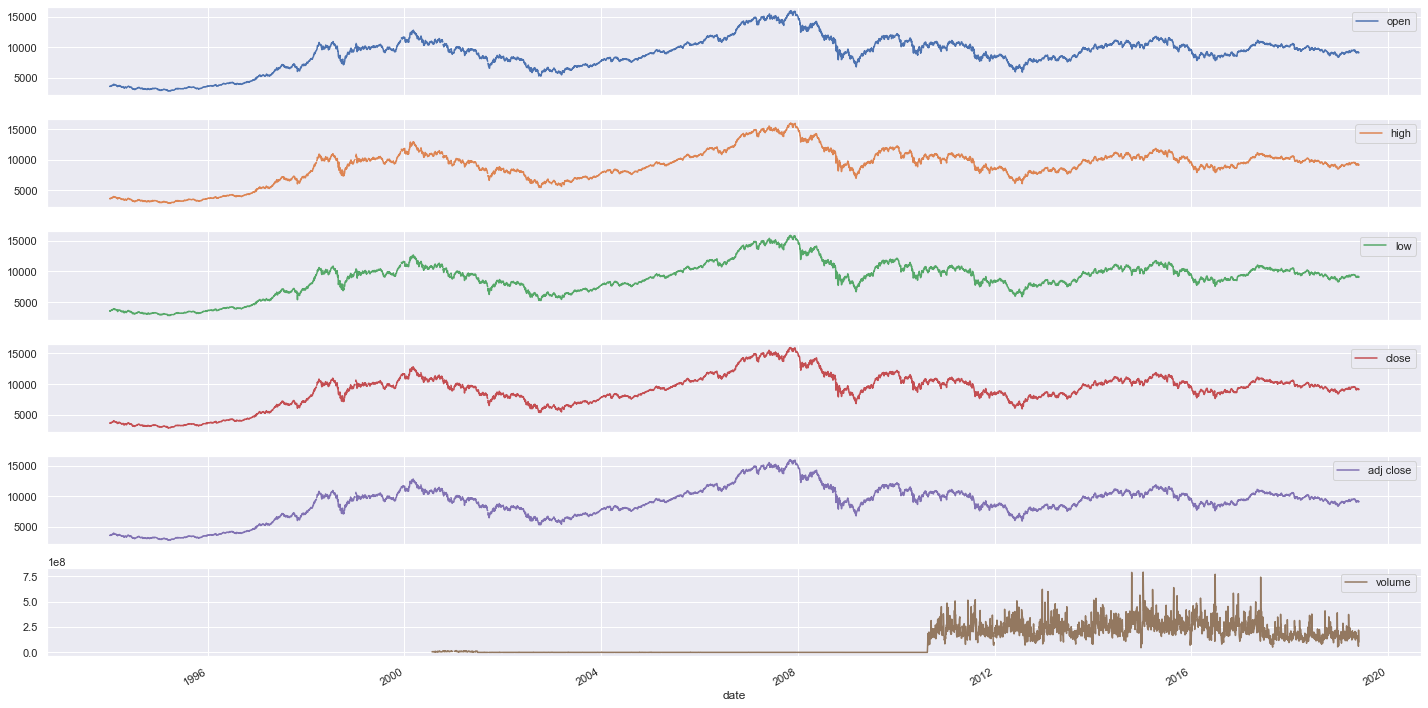

In [5]:
_ = df[df.columns.drop('target')].plot(subplots=True, figsize=(20,10), sharex=True)
plt.tight_layout()

In [8]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(rows=1, cols=1, shared_xaxes=True)

fig.add_trace(go.Candlestick(
                  x=df.index[-100:],
                  open=df['open'][-100:],
                  high=df['high'][-100:],
                  low=df['low'][-100:],
                  close=df['close'][-100:], name='price'), row=1, col=1,
)
fig.update_xaxes(
    tickangle = -45,
    title_font = {"size": 20},
    nticks=50,
    showgrid=True, gridwidth=1, gridcolor='white'
)
#fig.add_trace(go.Bar(x=df['time'], y=df['volume'], name='volume'),
              #row=2, col=1)
fig.show()

<AxesSubplot:>

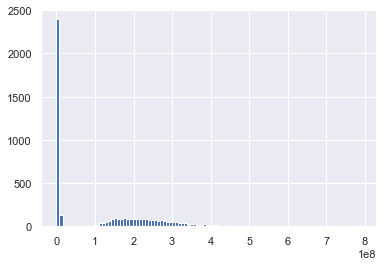

In [9]:
df['volume'].hist(bins=100)

In [22]:
def correlation(df):
  corr_mat = df.corr(method='pearson', min_periods=1)

  fig, ax = plt.subplots(1, 1, figsize=(6, 5))
  sns.heatmap(corr_mat, cmap="YlGnBu", linewidths=0.5, linecolor='black')
  ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 15)
  ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 15)
  ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)
  plt.setp(ax.get_xticklabels(), rotation=-40, ha="right",
             rotation_mode="anchor")

  # ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
  fig.tight_layout()
  ax.set_title('Correlation map', fontsize=23)
  plt.show()

Al hacer el analisis se ha visto que faltan fechas. Por un lado estan los dias que corresponden a sabado y domingo donde la bolsa no esta abierta. Por otro lado he realizado un analisis del resto de dias que faltan. Estos corresponden a festivos en España donde la bolsa tampoco abre. Descartando las fechas que son fines de semana y festivos, quedan 29 fechas que corresponden a dias laborales y que no tenemos dato de ello. En algunos casos el dia anterior a esas fechas era festivo, por lo que: **he asumido que en algunos casos los dias siguientes a los festivos tambien se consideraron festivos y la bolsa no abrio ese dia** y que la libreria *holidays* no los tuvo en cuenta como festivos. En conclusion, he decidido no rellenar ninguno de los dias que faltan, fiandome de los datos del concurso.

### 1.2 Analice dates that left

In [13]:
idx = pd.date_range(df.date[0], df.date[-1], freq='1B')
aux = df.reindex(idx)

import holidays
sp_holidays = holidays.Spain()

festivos = aux[aux['date'].isna()].index.to_series().apply(lambda x: sp_holidays.get(x))
print(festivos.values)
print(festivos.shape)
print(festivos[festivos.isna()].shape)

['Viernes Santo' None 'Día del Trabajador' 'Navidad' None 'Viernes Santo'
 None 'Día del Trabajador' 'Navidad' None None 'Año nuevo' 'Viernes Santo'
 None 'Día del Trabajador' None 'Navidad' None None 'Año nuevo'
 'Viernes Santo' None 'Día del Trabajador' None 'Navidad' None 'Año nuevo'
 'Viernes Santo' None None None 'Viernes Santo' None
 'Navidad (Trasladado)' 'Viernes Santo' None 'Día del Trabajador'
 'Navidad' None 'Año nuevo' 'Viernes Santo' None 'Día del Trabajador'
 'Navidad' None 'Año nuevo' 'Viernes Santo' None 'Día del Trabajador'
 'Navidad' None 'Año nuevo' 'Viernes Santo' None 'Día del Trabajador'
 'Navidad' 'Año nuevo' 'Viernes Santo' None 'Navidad (Trasladado)'
 'Viernes Santo' None 'Día del Trabajador' 'Navidad' None 'Año nuevo'
 'Viernes Santo' None 'Día del Trabajador' 'Navidad' None 'Año nuevo'
 'Viernes Santo' None 'Día del Trabajador']
(75,)
(29,)


## 2.Preprocesss

### 2.1 Interpolate

In [9]:
# Interpolate all columns as some of them has Nans
dfi = df.copy()
cols2inter = df.columns.drop('target')
dfi[cols2inter] = df[cols2inter].interpolate(method='spline', order=3, limit_direction='forward', axis=0)

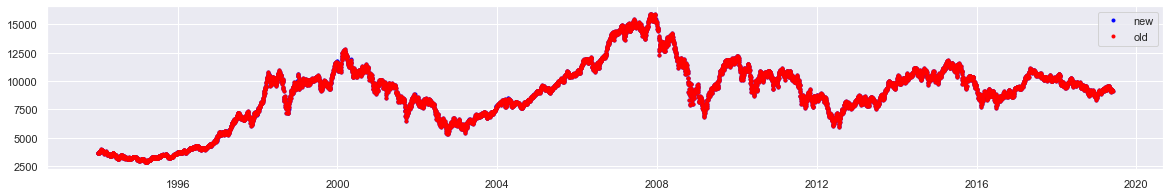

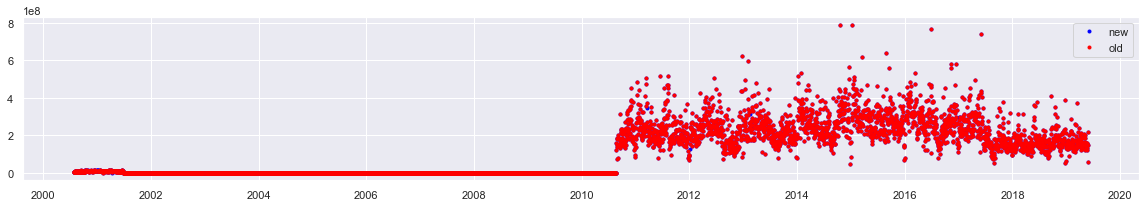

In [10]:
s = 0
e = -1

col = 'close'
fig = plt.figure(figsize=(20, 3))
plt.plot(dfi.index[s:e], dfi[col][s:e], '.', color='blue', label='new')
plt.plot(df.index[s:e], df[col][s:e], '.', color='red', label='old')
plt.legend()
plt.show()

col = 'volume'
fig = plt.figure(figsize=(20, 3))
plt.plot(dfi.index[s:e], dfi[col][s:e], '.', color='blue', label='new')
plt.plot(df.index[s:e], df[col][s:e], '.', color='red', label='old')
plt.legend()
plt.show()

### 2.2 Add new data

In [12]:
# Tech indicators are the main tools in Trading and the analysis of the stocks. In short, they are just ratios of how the price and/or volume are moving.
def add_tech_indicators(df, fillnans = True):
  import ta #https://technical-analysis-library-in-python.readthedocs.io/en/latest/

  df_tech = df.copy()

  #MOMENTUM
  indicator = ta.momentum.PercentagePriceOscillator(close = df_tech[f'close'],
                                                    window_slow = 26,
                                                    window_fast = 12,
                                                    window_sign = 9,
                                                    fillna = fillnans)
  df_tech[f'PPO'] = indicator.ppo()

  # indicator = ta.momentum.ROCIndicator(close = df_tech[f'close'], window = 12, fillna = fillnans)
  # df_tech[f'ROC'] = indicator.roc()

  # indicator = ta.momentum.RSIIndicator(close = df_tech[f'close'], window = 14, fillna = fillnans)
  # df_tech[f'RSI'] = indicator.rsi()

  indicator = ta.momentum.StochRSIIndicator(close = df_tech[f'close'], window = 7, smooth1 = 3, smooth2 = 3, fillna = fillnans)
  df_tech[f'StRSI'] = indicator.stochrsi()

  #VOLUME
  indicator = indicator = ta.volume.MFIIndicator(high = df_tech[f'high'],
                                                low = df_tech[f'low'],
                                                close = df_tech[f'close'],
                                                volume = df_tech[f'volume'],
                                                window = 7, fillna = fillnans)
  df_tech[f'MFI'] = indicator.money_flow_index()

  #VOLATILITY
  # indicator = ta.volatility.DonchianChannel(high = df_tech[f'high'],
  #                                           low = df_tech[f'low'],
  #                                           close = df_tech[f'close'],
  #                                           window = 20, offset = 0, fillna = fillnans)
  # df_tech[f'mDNCH'] = indicator.donchian_channel_mband()

  #TREND
  indicator = ta.trend.CCIIndicator(high = df_tech[f'high'],
                                    low = df_tech[f'low'],
                                    close = df_tech[f'close'],
                                    window = 14, constant = 0.015, fillna = fillnans)
  df_tech[f'CCI'] = indicator.cci()
  max_bound = 500
  df_tech[f'CCI'][df_tech[f'CCI'] > max_bound] = max_bound
  df_tech[f'CCI'][df_tech[f'CCI'] < -max_bound] = -max_bound

  indicator = ta.trend.EMAIndicator(close = df_tech[f'close'], window = 7, fillna = fillnans)
  df_tech[f'EMA'] = indicator.ema_indicator()

  # indicator = ta.trend.MACD(close = df_tech[f'close'], window_slow = 26, window_fast = 12, window_sign = 9, fillna = fillnans)
  # df_tech[f'MACD'] = indicator.macd()

  #TYPICAL PRICE
  df_tech['typical'] = (df_tech[f'high'] + df_tech[f'low'] + df_tech[f'close']) / 3.0

  return df_tech

# Dates cant be interpreted well by the model as he doesnt understand than monday goes after sunday. Transforming dates to sin/cos lets us create cycles.
def parse_date_to_sin_cos(df_raw):

  day_sec   = 24 * 60 * 60
  week_sec  = day_sec * 7
  year_sec  = day_sec * 365.2425

  df = df_raw.copy()
  timestamp_s = df.index.map(datetime.datetime.timestamp)
  df['wcos']   = np.cos(timestamp_s * (2.0 * np.pi / week_sec))
  df['ycos']   = np.cos(timestamp_s * (2.0 * np.pi / year_sec))
  # df['dcos']    = np.cos(timestamp_s * (2.0 * np.pi / day_sec))

  return df


In [13]:
# If we want to use volume column, we should discard first half of dates
# df = dfi
df = dfi[dfi['date'] > '2011-01-01']

In [14]:
# Balanced?
print(df['target'].value_counts())

1    1123
0    1027
Name: target, dtype: int64


In [15]:
df = add_tech_indicators(df)
# df = parse_date_to_sin_cos(df)

c:\Users\anton\anaconda3\envs\ML\lib\site-packages\ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\Users\anton\anaconda3\envs\ML\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


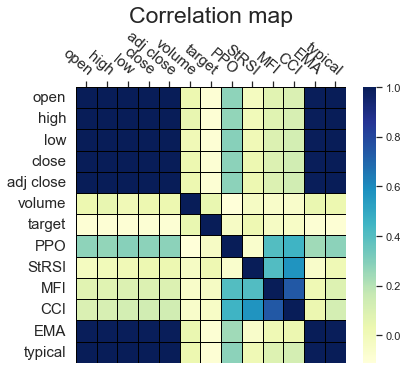

In [23]:
correlation(df)

### 2.3 Decide target

In [24]:
# After many experiments, the neural network models had problems learning as classifiers
# Using as target the future price, showed better results. Having the price on day0 and day+3 we canb calculate the real target.
df['target_close'] = df['close'].shift(-3)
df = df.drop(['date','target'], axis=1)
df = df.dropna()

In [26]:
df.describe()

,open,high,low,close,adj close,volume,PPO,StRSI,MFI,CCI,EMA,typical,target_close
count,2147.000000,2147.000000,2147.000000,2147.000000,2147.000000,2.147000e+03,2147.000000,2147.000000,2147.000000,2147.000000,2147.000000,2147.000000,2147.000000
mean,9436.754079,9505.442309,9354.623644,9432.169318,9432.163118,2.358039e+08,-0.034670,0.512560,51.030594,0.825752,9433.133214,9430.745090,9431.168851
std,1134.786208,1129.251764,1139.363960,1134.945656,1134.945204,8.900012e+07,1.319289,0.403062,22.154263,107.174043,1124.550457,1133.771136,1134.884487
min,5950.399902,6093.100098,5905.299805,5956.299805,5956.293945,4.520760e+07,-4.772995,0.000000,0.000000,-329.287581,6240.213320,6012.466634,5956.299805
25%,8598.250000,8659.949707,8515.449707,8596.750000,8596.745606,1.704224e+08,-0.738333,0.057856,35.453864,-82.481321,8576.748301,8592.783366,8596.750000
50%,9537.000000,9593.000000,9468.099609,9531.099609,9531.099609,2.227916e+08,0.073152,0.509852,50.757813,0.288279,9541.217349,9532.233073,9527.200195
75%,10349.449707,10410.200195,10270.600098,10339.299805,10339.289063,2.844086e+08,0.768253,0.995082,68.565479,88.384715,10319.823924,10340.216471,10339.299805
max,11798.500000,11884.599609,11760.799805,11866.400391,11866.388672,7.894902e+08,3.554031,1.000000,100.000000,356.439841,11726.179281,11837.266602,11866.400391


## 3.Train

### 3.1 Neural Networks

In [27]:
import tensorflow as tf
import sklearn
print(f'tensorflow version: {tf.__version__}')
print(f'sklearn version: {sklearn.__version__}')

from keras.models import load_model
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv1D, LSTM, GRU, Bidirectional
from tensorflow.keras.layers import Input, Activation, LeakyReLU,  ReLU, Embedding, Dropout, BatchNormalization
from tensorflow.keras.initializers import he_uniform

from tensorflow.keras import backend as K
from tensorflow.python.framework import ops
from tensorflow.python.ops import math_ops

# tf.random.set_seed(1234)
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer, QuantileTransformer, RobustScaler

tensorflow version: 2.8.0
sklearn version: 1.0.2


#### 3.1.1 Utils

In [28]:
def histories_mean(histories):
  """Make the mean learning curve of the kfolds
  """
  history_array = histories #copy histories
  history_mean = history_array[0] #get first kfold
  epochs = len(histories[0].history['loss'])
  nfolds = len(histories)
  # print(epochs, nfolds)

  for i in range(epochs):
    for j in range(1, nfolds):
      if i >= len(history_array[j].history['loss']):
        continue
      history_mean.history['loss'][i] += history_array[j].history['loss'][i]
      history_mean.history['val_loss'][i] += history_array[j].history['val_loss'][i]

    history_mean.history['loss'][i] /= nfolds
    history_mean.history['val_loss'][i] /= nfolds

  return history_mean

def plot_learning_curves(histories, title):
  """Plots the learning curve of the kfolds
  """
  history_mean = histories_mean(histories)

  fig = plt.figure(figsize=(20, 4))
  start_epoch = 5 #first epocs are too big
  # Loss plots
  ax1 = fig.add_subplot(1, 2, 1)
  ax1.set_title('Loss')
  ax1.set_xlabel('epochs')
  ax1.set_ylabel('loss')
  ax1.plot(history_mean.history['loss'][start_epoch:], color='blue', label='train')
  ax1.plot(history_mean.history['val_loss'][start_epoch:], color='orange', label='validation')

  if 'accuracy' in history_mean.history.keys():
    ax2 = fig.add_subplot(1, 2, 2)
    ax2.set_title('accuracy')
    ax2.set_xlabel('epochs')
    ax2.set_ylabel('accuracy')
    ax2.plot(history_mean.history['accuracy'][start_epoch:], color='blue', label='train')
    ax2.plot(history_mean.history['val_accuracy'][start_epoch:], color='orange', label='validation')

  plt.subplots_adjust(top=0.85, bottom=0.10, left=0.05, right=0.95, hspace=0.5, wspace=0.40)

  plt.legend()
  plt.suptitle(title)
  plt.show()

In [29]:

def transform_data_to_lstm (df_raw, cols, scaler, past_size=5, fit=False, pct_change=False):
  """In order to use LSTM architectures we need to reshape the data
  """
  df = df_raw.copy()
  # save outputs before scaling the data
  LSTM_output = df['target_close'][past_size-1:-1]

  if not pct_change:
    scaler, df = scale(df, cols_to_scale=cols, scaler=scaler, fit=fit)

  LSTM_inputs = []
  for i in range(len(df)-past_size):
    tmp_df = df[cols][i:(i+past_size)].copy()
    if pct_change:
      cols_change = ['open',	'high',	'low','close','adj close','volume','typical']
      tmp_df[cols_change] = tmp_df[cols_change].pct_change(1)   # Transform values from absolute to relative %
      tmp_df = tmp_df.iloc[1:]
    LSTM_inputs.append(tmp_df)

  return   np.asarray(LSTM_inputs), LSTM_output, scaler

def get_ready_data(df_raw, scaler, kind=1, past_size=5, fit=False, pct_change=False):
  """Prepare the data ready for training. The data format is indicated by @kind argument
  """
  dfx = dfy = pd.DataFrame()
  df = df_raw.copy()
  cols_to_scale = df.columns.to_list()
  cols_to_scale.remove(f'target_close')

  if kind == FORWARD_:
    scaler, df = scale(df, cols_to_scale=cols_to_scale, scaler=scaler, fit=fit)
    dfx, dfy = df[cols_to_scale], df['target_close']

  elif kind == LSTM_:
    dfx, dfy, scaler = transform_data_to_lstm(df, cols=cols_to_scale, scaler=scaler, past_size=past_size, fit=fit, pct_change=pct_change)
  else:
    print("Unexpected error")
    raise

  return dfx, dfy, scaler

In [30]:
# Best scalers by experience
scaler_list = {
    'Standard'  : StandardScaler(),
    'MinMax'    : MinMaxScaler(feature_range=(0, 1)),
    'Robust'    : RobustScaler(quantile_range=(25, 75)),
    # 'Power'     : PowerTransformer(method='yeo-johnson'),
    # 'Quantile-uniform' :  QuantileTransformer(output_distribution='uniform'),
    # 'Quantile-normal'  :  QuantileTransformer(output_distribution='normal')
}

def scale(df, cols_to_scale, scaler, fit=False):
  """Scale the columns of a dataset
  """
  df_copy = df.copy()
  cols_not_scaled = [col for col in df_copy.columns if col not in cols_to_scale]

  if fit:
    scaler = scaler.fit(df_copy[cols_to_scale])
    print(f'Fit: {fit}')

  # Transform dataset
  scaled = scaler.transform(df_copy[cols_to_scale])
  scaled = pd.DataFrame(data=scaled, index=df_copy.index, columns=cols_to_scale)
  scaled = scaled.join(df_copy[cols_not_scaled])
  return scaler, scaled

In [31]:
def SMAPE(y_true, y_pred):
  """Custom loss functions. In my opinion the best loss function ever when we have a regression problem with undefined limit of possible real value
  """
  y_pred = ops.convert_to_tensor_v2_with_dispatch(y_pred)
  y_true = math_ops.cast(y_true, y_pred.dtype)

  nom = tf.math.abs(y_pred-y_true)
  denom = tf.maximum(tf.math.abs(y_pred) + tf.math.abs(y_true), tf.constant([0.00001], dtype=nom.dtype))
  denom = tf.divide(denom, 2.0)
  results = tf.divide(nom, denom)
  results = 100.0 * tf.reduce_mean(results)

  return results

#### 3.1.2 Models

In [32]:
def custom_dense(size, activation = ReLU()):
  x = Dense(
      size, activation=activation,
      # kernel_regularizer=tf.keras.regularizers.L2(l2=0.001),
      kernel_initializer=tf.keras.initializers.RandomUniform()
  )
  return x

def custom_lstm(size, return_sequences):
  x = LSTM(
      size, activation='relu'
    , return_sequences=return_sequences
    # , kernel_regularizer=tf.keras.regularizers.L2(l2=0.001)
    , kernel_initializer=tf.keras.initializers.RandomUniform()
  )
  return x

def custom_gru(size, return_sequences):
  x = GRU(
      size, activation='relu'
    , return_sequences=return_sequences
    # , kernel_regularizer=tf.keras.regularizers.L2(l2=0.001)
    , kernel_initializer=tf.keras.initializers.RandomUniform()
  )
  return x


In [33]:
def DenseBasic(input_size, output_size, output_activation='sigmoid'):
  activation = ReLU()
  layer0 = 1024
  layers = [
    custom_dense(layer0, activation),
    Dropout(0.5),
    custom_dense(layer0//2, activation),
    Dropout(0.5),
    custom_dense(layer0//4, activation),
    custom_dense(layer0//8, activation),
  ]

  inputs = Input(shape=input_size)
  x = Flatten()(inputs)

  for layer in layers:
    x = layer(x)

  output = custom_dense(output_size, activation=output_activation)(x)

  return keras.Model(inputs=inputs, outputs=output, name='Dense_basic')

def DenseResid(input_size, output_size, output_activation='sigmoid'):
  activation = ReLU()
  layer0 = 1024
  layers = [
            custom_dense(layer0, activation),
            Dropout(0.5),
            custom_dense(layer0//2, activation),
            Dropout(0.5),
            custom_dense(layer0//4, activation),
            custom_dense(layer0//8, activation),
  ]

  inputs = Input(shape=input_size)
  x = Flatten()(inputs)

  x = layers[0](x)
  tmp = x
  for i in range(1, len(layers)):
    x = layers[i](x)
    tmp = tf.keras.layers.Concatenate(axis=1)([tmp, x])
  x = tmp

  output = custom_dense(output_size, activation=output_activation)(x)

  return keras.Model(inputs=inputs, outputs=output, name='Dense_resid')

def RecurrentLSTM(input_size, output_size, output_activation='sigmoid'):
  layers = [
            custom_lstm(8, return_sequences=True),
            Dropout(0.5),
            custom_lstm(8, return_sequences=False),
            Dropout(0.3),
            custom_dense(4, activation='relu'),
  ]

  inputs = Input(shape=input_size)
  x = inputs

  for layer in layers:
    x = layer(x)

  output = custom_dense(output_size, activation=output_activation)(x)

  return keras.Model(inputs=inputs, outputs=output, name='LSTM_basic')

def RecurrentGRU(input_size, output_size, output_activation='sigmoid'):
  layers = [
            custom_gru(8, return_sequences=True),
            custom_gru(8, return_sequences=False),
  ]

  inputs = Input(shape=input_size)
  x = inputs

  for layer in layers:
    x = layer(x)

  output = custom_dense(output_size, activation=output_activation)(x)

  return keras.Model(inputs=inputs, outputs=output, name='GRU_basic')


#### 3.1.3 Training

Here I have tried my different NN models but any of them showed good results (>51% accuracy). Neither regression or classification aproach.

In [128]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

FORWARD_, LSTM_ = 1, 2
kind = LSTM_ #LSTM_ #FORWARD_ #
target = 'target_close'

tscv = TimeSeriesSplit(n_splits=2, test_size=df.shape[0]//10)
histories = []; evaluates = []

for index, (train_index, val_index) in enumerate(tscv.split(df)):
  print("TRAIN:", train_index.shape, "VAL:", val_index.shape)
  X_train, X_val = df.iloc[train_index].copy(), df.iloc[val_index].copy()
  train_close = X_train['close'].values
  val_close = X_val['close'].values

  scalerX = scaler_list["Standard"]
  LR     = 1e-3
  OPTIMIZER     = tf.keras.optimizers.Adam(learning_rate=LR, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False)
  KERNEL_REGULARIZER  = tf.keras.regularizers.l2(l2=0.0001)

  if kind == LSTM_:
    X_train,  y_train,  scalerX = get_ready_data(X_train, scaler=scalerX, kind=kind, fit=True, past_size=5, pct_change=False)
    X_val,    y_val,    scalerX = get_ready_data(X_val, scaler=scalerX, kind=kind, fit=False, past_size=5, pct_change=False)
    model = RecurrentLSTM(input_size=X_train.shape[1:], output_size=1, output_activation='relu')
  else:
    X_train, y_train = X_train.drop(target, axis=1), X_train[target]
    X_val, y_val = X_val.drop(target, axis=1), X_val[target]
    model = DenseBasic(input_size=X_train.shape[1:], output_size=1, output_activation='relu') # #binary_crossentropy

  #======================= MODEL FIT =======================

  model.compile(loss=SMAPE, optimizer=OPTIMIZER, metrics=['mape']) #binary_crossentropy
  # if index == 0:
  #   model.summary()

  epochs        = 100
  batch_size    = 64
  history = model.fit(X_train, y_train.values, batch_size=batch_size, epochs=epochs , validation_data=(X_val, y_val), verbose=1, shuffle=True)# callbacks=[ cp_early_stop ])
  histories.append(history)
  # plot_learning_curves(histories, "learning curves")

  #======================= EVALUATE MODEL =======================
  results = model.evaluate(X_val, y_val, batch_size=batch_size)
  evaluates.append(results)  

  pred_train = model.predict(X_train).flatten()
  pred_test = model.predict(X_val).flatten()

  # Using LSTM we discard some rows
  if len(train_close) > len(y_train):
    train_close = train_close[-len(y_train):]
    val_close = val_close[-len(y_val):]

  train_target = (y_train > train_close).astype(int)
  train_target_pred = (pred_train > train_close).astype(int)
  train_acc = 1 - (abs(train_target_pred - train_target)).sum() / len(train_target)

  val_target = (y_val > val_close).astype(int)
  val_target_pred = (pred_test > val_close).astype(int)
  val_acc = 1 - (abs(val_target_pred - val_target)).sum() / len(val_target)

  print("ACCURACY: ", train_acc, val_acc)

  # break


TRAIN: (1719,) VAL: (214,)
Fit: True
Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
26/27 [===========================>..] - ETA: 0s - loss: 199.9994 - mape: 99.9999WARNING: AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000002B619114288> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
27/27 [==============================] - 4s 68ms/step - loss: 199.9994 - mape: 99.9999 - val_loss: 199.99

### 3.2 Trees

As in most of the ML problems, Boost and Bagging algorithms usually works better than NN models. Here I have tried different aproached using also different trees implemented in *sklean* library.

In [59]:
from xgboost import XGBClassifier, XGBRegressor
from sklearn.ensemble import RandomForestRegressor, VotingRegressor, ExtraTreesRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold, KFold, TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5, test_size=df.shape[0]//10)
histories = []; evaluates = []
if 'date' in df.columns:
  df = df.drop('date', axis=1)

results = []
for index, (train_index, val_index) in enumerate(tscv.split(df)):
  X_train, X_val = df.iloc[train_index].copy(), df.iloc[val_index].copy()

  target = 'target_close'
  X_train, y_train = X_train.drop(target, axis=1), X_train[target]
  X_val, y_val = X_val.drop(target, axis=1), X_val[target]
  # save real close price in case we scale the data
  train_close = X_train['close'].values
  val_close = X_val['close'].values

  # PCA finds insignificant every feature and doesnt detect any usefull components.
  # from sklearn.decomposition import PCA
  # pca = PCA(0.98)
  # pca = pca.fit(X_train)
  # X_train = pca.transform(X_train)
  # X_val = pca.transform(X_val)

  print("KFOLD:", index, "TRAIN:", X_train.shape, "VAL:", X_val.shape)

  # xgb = XGBRegressor(verbosity=0, n_estimators=1000, max_depth=4, subsample=0.08, colsample_bylevel=0.2,)
  lr = LinearRegression()
  rf = RandomForestRegressor(max_depth=10, n_estimators=1000,  random_state=0, verbose=0)
  dt = DecisionTreeRegressor(max_depth = 4, random_state=0)
  etr = ExtraTreesRegressor(max_depth=4, random_state=0, n_estimators=1000, )

  model = VotingRegressor([('lr', lr),('rf', rf), ('dt', dt), ('etr', etr)], verbose=0)
  model = model.fit(X_train, y_train)

  pred_train = model.predict(X_train).flatten()
  pred_val = model.predict(X_val).flatten()

  train_target = (y_train > train_close).astype(int)
  train_target_pred = (pred_train > train_close).astype(int)
  train_acc = 1 - (abs(train_target_pred - train_target)).sum() / len(train_target)
  train_f1 = f1_score(train_target, train_target_pred)

  val_target = (y_val > val_close).astype(int)
  val_target_pred = (pred_val > val_close).astype(int)
  val_acc = 1 - (abs(val_target_pred - val_target)).sum() / len(val_target)
  val_f1 = f1_score(val_target, val_target_pred)

  print("F1 (TRAIN | VAL): ", round(train_f1, 4), "|", round(val_f1, 4))
  print("ACC (TRAIN | VAL): ", round(train_acc, 4), "|", round(val_acc, 4))
  results.append([train_acc, val_acc])

results = np.array(results)
results_mean = results.mean(axis=0)
print(f"FINAL ACCURACY. TRAIN: {round(results_mean[0],4)}, VAL: {round(results_mean[1], 4)}")

KFOLD: 0 TRAIN: (1077, 12) VAL: (214, 12)
F1 (TRAIN | VAL):  0.7696 | 0.3727
ACC (TRAIN | VAL):  0.7604 | 0.528
KFOLD: 1 TRAIN: (1291, 12) VAL: (214, 12)
F1 (TRAIN | VAL):  0.735 | 0.4972
ACC (TRAIN | VAL):  0.7397 | 0.5748
KFOLD: 2 TRAIN: (1505, 12) VAL: (214, 12)
F1 (TRAIN | VAL):  0.7156 | 0.4412
ACC (TRAIN | VAL):  0.7196 | 0.4673
KFOLD: 3 TRAIN: (1719, 12) VAL: (214, 12)
F1 (TRAIN | VAL):  0.7173 | 0.6129
ACC (TRAIN | VAL):  0.7144 | 0.5514
KFOLD: 4 TRAIN: (1933, 12) VAL: (214, 12)
F1 (TRAIN | VAL):  0.7186 | 0.4683
ACC (TRAIN | VAL):  0.7175 | 0.4907
FINAL ACCURACY. TRAIN: 0.7303, VAL: 0.5224


Plot the predictions in order to see if there is some pattern which could be resolved

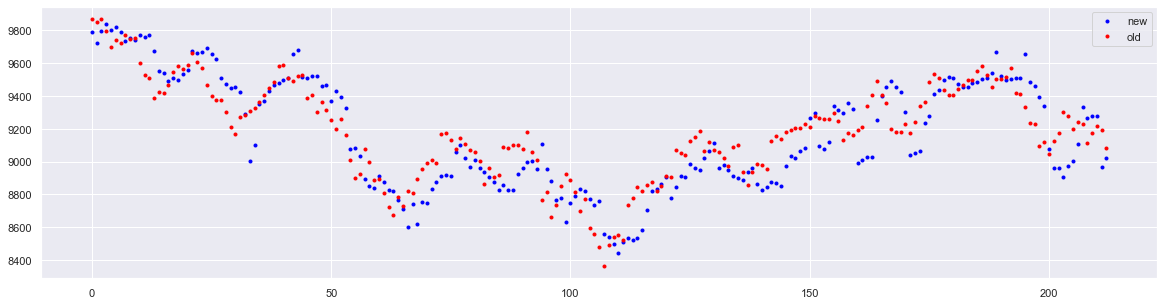

In [90]:
s = 0
e = -1

col = 'close'
fig = plt.figure(figsize=(20, 5))
plt.plot(pred_val[s:e], '.', color='blue', label='new')
plt.plot(y_val.values[s:e], '.', color='red', label='old')
plt.legend()
plt.show()

## 4. Train final model

In [61]:
if 'date' in df.columns:
  df = df.drop('date', axis=1)

X_train, X_val = df.copy(), df.copy()
X_train, y_train = X_train.drop(target, axis=1), X_train[target]
train_close = X_train['close'].values

lr = LinearRegression()
rf = RandomForestRegressor(max_depth=10, n_estimators=1000,  random_state=0, verbose=0)
dt = DecisionTreeRegressor(max_depth = 4, random_state=0)
etr = ExtraTreesRegressor(max_depth=4, random_state=0, n_estimators=1000, )

model = VotingRegressor([('lr', lr),('rf', rf), ('dt', dt), ('etr', etr)], verbose=0)
model = model.fit(X_train, y_train)

pred_train = model.predict(X_train).flatten()

train_target = (y_train > train_close).astype(int)
train_target_pred = (pred_train > train_close).astype(int)
train_acc = 1 - (abs(train_target_pred - train_target)).sum() / len(train_target)
train_f1 = f1_score(train_target, train_target_pred)

print("F1: ", round(train_f1, 4))
print("ACC: ", round(train_acc, 4))


F1:  0.7094
ACC:  0.7108


## 5. Create submission

In [70]:
df_test = pd.read_csv(TEST_PATH)
print(df_test.shape, "raw shape test")

# Change columns name
new_col_names = {x : x.lower() for x in df_test.columns}
df_test.rename(columns=new_col_names, inplace=True)

# Volume == 0 considered an error
condicion = df_test['volume'] == 0
df_test.loc[condicion, 'volume'] = np.nan

display(df_test[df_test.isna().any(axis=1)])
# No need to interpolate, thanks god

df_test = add_tech_indicators(df_test)
df_test['target_close'] = df_test['close'].shift(-3) # in case we want to calculate MAE
print(df_test.shape, "ensure that we have not removed any row")

(726, 8) raw shape test


,test_index,date,open,high,low,close,adj close,volume


(726, 15) ensure that we have not removed any row


c:\Users\anton\anaconda3\envs\ML\lib\site-packages\ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\Users\anton\anaconda3\envs\ML\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [82]:
X_test, y_test = df_test.drop([target, 'date', 'test_index'], axis=1), df_test[target]
test_close = df_test['close'].values

pred_test = model.predict(X_test).flatten()

test_target = (y_test[:-3] > test_close[:-3]).astype(int)
test_target_pred = (pred_test[:-3] > test_close[:-3]).astype(int)
test_acc = 1 - (abs(test_target_pred - test_target)).sum() / len(test_target)
test_f1 = f1_score(test_target, test_target_pred)

print("F1: ", round(test_f1, 4))
print("ACC: ", round(test_acc, 4))
print("SMAPE: ", round(SMAPE(y_test[:-3], pred_test[:-3]).numpy(), 4))

F1:  0.4861
ACC:  0.4882
SMAPE:  1.8036


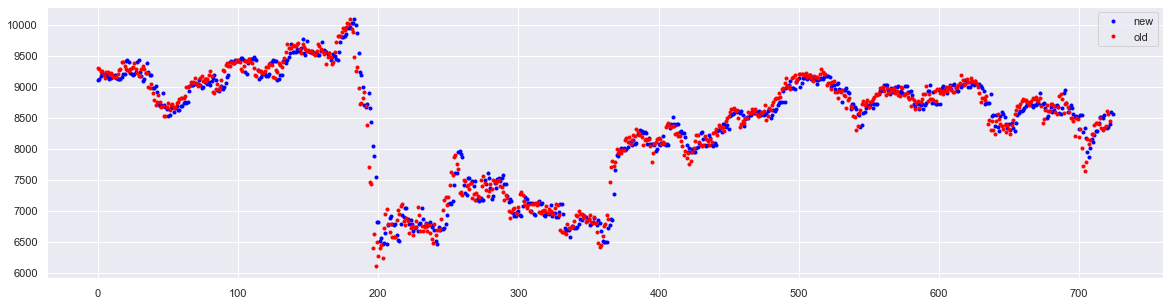

In [89]:
s = 0
e = -1

col = 'close'
fig = plt.figure(figsize=(20, 5))
plt.plot(pred_test[s:e], '.', color='blue', label='new')
plt.plot(y_test.values[s:e], '.', color='red', label='old')
plt.legend()
plt.show()

In [98]:
df_submit = df_test.copy()
pred_test = model.predict(X_test).flatten()
test_target_pred = (pred_test > test_close).astype(int)
df_submit['Target'] = test_target_pred.astype(int)

df_submit

,test_index,date,open,high,low,close,adj close,volume,PPO,StRSI,MFI,CCI,EMA,typical,target_close,Target
0,6557,2019-06-05,9136.799805,9173.400391,9095.000000,9150.500000,9150.500000,158753000.0,0.000000,0.000000,50.000000,0.000000,9150.500000,9139.633464,9294.099609,0
1,6558,2019-06-06,9169.200195,9246.200195,9136.700195,9169.200195,9169.200195,212720900.0,0.016300,0.000000,100.000000,66.666667,9155.175049,9184.033528,9282.099609,0
2,6559,2019-06-07,9186.700195,9261.400391,9185.700195,9236.099609,9236.099609,150664700.0,0.087138,0.000000,100.000000,99.471551,9175.406189,9227.733398,9238.500000,0
3,6560,2019-06-10,9284.200195,9302.200195,9248.099609,9294.099609,9294.099609,102323700.0,0.191964,0.000000,100.000000,105.281977,9205.079544,9281.466471,9247.099609,0
4,6561,2019-06-11,9288.599609,9332.500000,9273.400391,9282.099609,9282.099609,144701200.0,0.261298,0.000000,100.000000,91.526905,9224.334560,9296.000000,9194.200195,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
721,7278,2022-03-25,8314.099609,8363.200195,8286.500000,8330.599609,8330.599609,156189000.0,-0.187358,0.134238,33.983815,30.408703,8337.440765,8326.766601,8550.599609,1
722,7279,2022-03-28,8354.400391,8485.700195,8354.400391,8365.599609,8365.599609,167961800.0,-0.122738,0.325872,48.384227,61.391109,8344.480476,8401.900065,8445.099609,1
723,7280,2022-03-29,8451.000000,8621.000000,8419.700195,8614.599609,8614.599609,257812200.0,0.167243,1.000000,71.844834,148.056137,8412.010259,8551.766601,NaN,0
724,7281,2022-03-30,8583.299805,8597.400391,8508.900391,8550.599609,8550.599609,185389000.0,0.330579,0.677935,72.677252,144.029387,8446.657597,8552.300130,NaN,1


In [102]:
df_submit[['test_index', 'Target']].to_csv("predictions.csv", header=True, index=False)

In [106]:
df_submit[['test_index', 'Target']].to_json('predictions.json', orient="table", index=False, indent=2)